# Real-world Data Wrangling

# 1. Gather data

In [1]:
import pandas as pd # To work with dataframes
import numpy as np # To work numerical computing
import os    # To interact with the operating system
import requests # To download the dataset via HTTP
import matplotlib.pyplot as plt # To plot the data
import seaborn as sns # Advanced plotting

### 1.1 Problem Statement

The NHL Draft is a pivotal event where teams select young talent from around the world with the goal of improving their future performance. This project aims to analyze historical NHL draft data in conjunction with socioeconomic indicators, such as GDP per capita and population data from the World Bank, to identify trends and potential predictors of player success in the NHL. Specifically, we will investigate whether a player's pre-draft league and their country of origin's socioeconomic status impact their likelihood of playing in the NHL.

#### Key Research Questions:

1. **How does a player’s pre-draft league impact their likelihood of playing in the NHL?**
 - Which leagues produce the highest percentage of players who make the NHL? 
 - Do certain leagues produce longer NHL careers than others?
 - Is there a difference in NHL performance (games played, points, etc.) by league?

2. **Do countries with larger populations or higher GDP per capita produce more NHL players?**
- Which countries produce the most NHL players per capita?
- Does GDP per capita or population size correlate with NHL success?
- Are there wealthy, populous countries that underperform in NHL production?

3. **Are there “hockey overachievers"?** 
- Which countries produce NHL players despite lower socioeconomic indicators?
- Which small or low-GDP countries produce an outsized number of NHL players?
- Are there any underdeveloped hockey markets that could become the next big producer?
- How do these countries compare to traditional hockey powerhouses?

### 1.2 Gathering three datasets using two different data methods

#### Data Gathering Methods:

- Manual Download: Downloaded datasets from Kaggle.

- API Access: Pulled using pandas


#### Dataset Descriptions:


NHL Draft dataset:

 - Source: Kaggle

 - Method: Manual Download


Population Data:

 - Source: World Bank API

 - Method: API Access


GDP per Capita:

 - Source: World Bank API
 
 - Method: API Access

#### Dataset 1 - NHL Draft 
Source: Sourced from Kaggle via manual download.

Type: CSV File

Dataset variables: 
 - Draft Details: `Year`, `overall pick`, `drafting team`, and `player name`.
 - Player Information: `Nationality`, `position`, and `age`.
	 
 - Career Stats: `Games played`, `goals`, `assists`, `points`, `plus-minus`, `penalty minutes`, and more.
     
  - Goalie Stats: `Wins`, `losses`, `save percentage`, and `goals-against average` (where applicable).

#### Dataset 2 - Population

Source: World Bank API

Type: CSV File

Dataset variables:
 - Country Name: To merge with the NHL Draft dataset.
 - Year: To analyze population trends over time.
 - Population: The key variable to measure population.

#### Dataset 3 - GDP per capita (current US$)

Source: World Bank API

Type: CSV File


Dataset variables:
 - Country Name: Name of the country.
 - Year: Year of the recorded data.
 - GDP per capita: Gross Domestic Product per capita in USD.

### 1.3 Load Datasets

NHL Draft Dataset: 

Loaded via a manual download from Kaggle:
https://www.kaggle.com/datasets/mattop/nhl-draft-hockey-player-data-1963-2022

In [2]:
# 1st dataset
raw_NHL = pd.read_csv('Database1/nhldraft.csv', index_col=False)

In [3]:
# Example of unique country codes from the NHL dataset
NHL_countries = raw_NHL['nationality'].unique()
print(NHL_countries)

['SK' 'US' 'CA' 'SE' 'CZ' 'AT' 'RU' 'FI' 'CH' 'DE' 'LV' 'PL' 'BY' 'GB'
 'KZ' 'NO' 'UA' 'UZ' 'DK' 'AU' 'TH' 'JM' 'FR' 'SI' 'BE' 'NL' 'CN' 'LT' nan
 'IT' 'NG' 'EE' 'JP' 'ME' 'HU' 'YU' 'BS' 'BR' 'TZ' 'BN' 'KR' 'ZA' 'SU'
 'HT' 'TW' 'PY' 'VE']


In [4]:
# 2nd and 3rd database / 2nd method
# Define the base URL for the World Bank API
base_url = "https://api.worldbank.org/v2/country/{country_code}/indicator/{indicator_code}"

# Function to fetch data from the World Bank API with error handling
def fetch_world_bank_data(country_code, indicator_code, start_year, end_year):
    url = base_url.format(country_code=country_code.lower(), indicator_code=indicator_code)
    params = {
        'format': 'json',
        'date': f'{start_year}:{end_year}',
        'per_page': 1000
    }
    
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()  # Raises HTTP Error for any bad responses
        data = response.json()
        
        # Validate the response format
        if isinstance(data, list) and len(data) > 1 and isinstance(data[1], list):
            return [{'country_code': country_code, **item} for item in data[1]]
        else:
            print(f"No valid data found for {country_code} with indicator {indicator_code}.")
    
    except requests.RequestException as e:
        print(f"Error fetching data for {country_code}: {e}")
    
    return []

# Define the indicators for population and GDP per capita
population_indicator = 'SP.POP.TOTL'
gdp_per_capita_indicator = 'NY.GDP.PCAP.CD'

# Store the data in dictionaries
population_data = []
gdp_per_capita_data = []

# Iterate over the unique NHL countries and fetch data
for country_code in NHL_countries:
    if pd.isna(country_code):  # Skip if country code is NaN
        print("Skipping NaN country code")
        continue
    
    # Fetch population and GDP per capita data
    pop_data = fetch_world_bank_data(country_code, population_indicator, 1963, 2022)
    gdp_data = fetch_world_bank_data(country_code, gdp_per_capita_indicator, 1963, 2022)
    
    # Add the data only if it's not empty
    if pop_data:
        population_data.extend(pop_data)
    if gdp_data:
        gdp_per_capita_data.extend(gdp_data)
    
# Function to convert the data to pandas dataframes with country code included
def convert_to_dataframe(data, indicator_name):
    return pd.DataFrame([
        {
            'country': item['country']['value'],
            'country code': item['country_code'].upper(),
            'year': int(item['date']),
            indicator_name: float(item['value'])
        }
        for item in data if item['value'] is not None
    ])

# Create DataFrames from World Bank API pulls
raw_POP = convert_to_dataframe(population_data, 'population')
raw_GDP = convert_to_dataframe(gdp_per_capita_data, 'gdp_per_capita')

# Save to CSV for later use
raw_POP.to_csv("population_data.csv", index=False)
raw_GDP.to_csv("gdp_per_capita_data.csv", index=False)

# Display the DataFrames
print("Population Data:")
print(raw_POP.head())

print("\nGDP per Capita Data:")
print(raw_GDP.head())

Skipping NaN country code
No valid data found for YU with indicator SP.POP.TOTL.
No valid data found for YU with indicator NY.GDP.PCAP.CD.
No valid data found for SU with indicator SP.POP.TOTL.
No valid data found for SU with indicator NY.GDP.PCAP.CD.
No valid data found for TW with indicator SP.POP.TOTL.
No valid data found for TW with indicator NY.GDP.PCAP.CD.
Population Data:
           country country code  year  population
0  Slovak Republic           SK  2022   5431752.0
1  Slovak Republic           SK  2021   5447247.0
2  Slovak Republic           SK  2020   5458827.0
3  Slovak Republic           SK  2019   5454147.0
4  Slovak Republic           SK  2018   5446771.0

GDP per Capita Data:
           country country code  year  gdp_per_capita
0  Slovak Republic           SK  2022    21342.766671
1  Slovak Republic           SK  2021    22138.194983
2  Slovak Republic           SK  2020    19735.485828
3  Slovak Republic           SK  2019    19406.058968
4  Slovak Republic        

### 1.3 Saving Copies of Datasets

In [5]:
# Store the raw data in your local data store
raw_NHL_data = raw_NHL.copy() 
raw_POP_data = raw_POP.copy()
raw_GDP_data = raw_GDP.copy()

Great! We now have copies to work with safety.

---

# 2. Assess data
We assess the three datasets according to data quality and tidiness metrics.

## 2.1 Assess Dataset 1: NHL Draft Dataset (1963 - 2022)
#### Assessing Quality Issues 

In [6]:
# Inspecting the dataframe visually
raw_NHL_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12250 entries, 0 to 12249
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     12250 non-null  int64  
 1   year                   12250 non-null  int64  
 2   overall_pick           12250 non-null  int64  
 3   team                   12249 non-null  object 
 4   player                 12250 non-null  object 
 5   nationality            12246 non-null  object 
 6   position               12223 non-null  object 
 7   age                    8291 non-null   float64
 8   to_year                5246 non-null   float64
 9   amateur_team           12250 non-null  object 
 10  games_played           5246 non-null   float64
 11  goals                  5246 non-null   float64
 12  assists                5246 non-null   float64
 13  points                 5246 non-null   float64
 14  plus_minus             5234 non-null   float64
 15  pe

In [7]:
# Check for missing values
NHL_total_missing = raw_NHL_data.isnull().sum()
print("Missing Values:\n", NHL_total_missing)

Missing Values:
 id                           0
year                         0
overall_pick                 0
team                         1
player                       0
nationality                  4
position                    27
age                       3959
to_year                   7004
amateur_team                 0
games_played              7004
goals                     7004
assists                   7004
points                    7004
plus_minus                7016
penalties_minutes         7004
goalie_games_played      11760
goalie_wins              11762
goalie_losses            11762
goalie_ties_overtime     11762
save_percentage          11762
goals_against_average    11760
point_shares              7004
dtype: int64


In [8]:
# Count any duplicate rows
print(f"Duplicate Entries:",raw_NHL_data.duplicated().sum())

Duplicate Entries: 0


In [9]:
# Check distribution of games played.
raw_NHL_data["games_played"].describe()

count    5246.000000
mean      305.384102
std       346.748283
min         1.000000
25%        25.000000
50%       151.500000
75%       521.000000
max      1779.000000
Name: games_played, dtype: float64

In [10]:
raw_NHL_data.sample(5)

,id,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,...,points,plus_minus,penalties_minutes,goalie_games_played,goalie_wins,goalie_losses,goalie_ties_overtime,save_percentage,goals_against_average,point_shares
12062,12063,1969,19,St. Louis Blues,Mike Lowe,CA,C,NaN,NaN,Loyola (CIAU),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9003,9004,1985,72,Los Angeles Kings,Perry Florio,US,D,NaN,NaN,Kent School (High-CT),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5609,5610,1998,17,Colorado Avalanche,Martin Skoula,CZ,D,18.0,2010.0,Barrie Colts (OHL),...,196.0,16.0,328.0,NaN,NaN,NaN,NaN,NaN,NaN,45.0
4446,4447,2003,291,Ottawa Senators,Brian Elliott,CA,G,18.0,2022.0,Ajax (OPJHL),...,10.0,0.0,12.0,521.0,267.0,159.0,52.0,0.91,2.53,77.7
1869,1870,2014,133,Arizona Coyotes,Dysin Mayo,CA,D,18.0,2022.0,Edmonton Oil Kings (WHL),...,12.0,-22.0,27.0,NaN,NaN,NaN,NaN,NaN,NaN,1.5


In [11]:
# Count unique teams
raw_NHL_data['amateur_team'].nunique()

1548

In [12]:
# Count occurrences of each amateur team
team_counts = raw_NHL_data['amateur_team'].value_counts().reset_index()
team_counts.head(10)

,amateur_team,count
0,USA U-18 Development Team (USDP/USHL),157
1,London Knights (OHL),134
2,Oshawa Generals (OHL),128
3,Soo Greyhounds (OHL),121
4,Peterborough Petes (OHL),118
5,Kitchener Rangers (OHL),111
6,Ottawa 67's (OHL),105
7,Kamloops Blazers (WHL),104
8,Saskatoon Blades (WHL),101
9,Brandon Wheat Kings (WHL),99


#### Quality Issues with Dataset 1: NHL Draft Dataset (1963 - 2022)
 - Datatypes are correct.
 - No duplicated rows.
 
 - `ID`, 0 missing - Column not necessary for merge or analysis.
  
Some Missing Values:
 - `team`, 1 missing
 - `nationality`, 4 missing
 - `position`, 27 missing
 - `age`, almost 40% missing, 3959 missing - Since we are missing age data for early drafts(1963-2001), we will: Exclude age as a factor in this analysis, and focus on league & country-based trends instead.
 
 - `to_year`, 7004 missing
 - `games_played`, 7004 missing - Quite a few players who did not play since being drafted.
 - `goals`, 7004 missing 
 - `assists`, 7004 missing
 - `points`, 7004 missing
 - `plus_minus`, 7016 missing
 - `penalties_minutes`, 7004 missing
 - `point_shares`, 7004 missing
 
 Majority Missing Values:
 - `goalie_games_played`, 11760 missing
 - `goalie_wins`, 11762 missing
 - `goalie_losses`, 11762 missing
 - `goalie_ties_overtime`, 11762 missing
 - `save_percentage`, 11762 missing
 - `goals_against_average`, 11760 missing

#### Assessing Tidiness Issues

In [13]:
# Inspecting the NHL Draft dataframe visually
raw_NHL_data.sample(5) 

,id,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,...,points,plus_minus,penalties_minutes,goalie_games_played,goalie_wins,goalie_losses,goalie_ties_overtime,save_percentage,goals_against_average,point_shares
3173,3174,2008,174,Washington Capitals,Greg Burke,US,LW,18.0,NaN,New Hampshire (EJHL),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7289,7290,1992,146,Ottawa Senators,Jaroslav Miklenda,CZ,G,NaN,NaN,TJ Olomouc (Czechoslovakia),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10055,10056,1981,128,Detroit Red Wings,Greg Stefan,CA,G,20.0,1990.0,Oshawa Generals (OHL),...,15.0,0.0,199.0,299.0,115.0,127.0,30.0,0.868,3.93,38.4
10891,10892,1977,183,Montreal Canadiens,John Costello,US,C,NaN,NaN,Massachusetts-Lowell (NCAA-II-Ind.),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7138,7139,1993,281,Montreal Canadiens,Russell Guzior,US,C,NaN,NaN,Culver Military Academy (High-IN),...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Tidiness Issues found with Dataset 1: NHL Draft Dataset (1963 - 2022)

 - `amateur_team` Split, contains addtional league data.
 - Goalie statistics are separate but mostly contain NaN for non-goalies.
    - A better structure would be **a separate table for goalies**.


## 2.2 Assess Dataset 2: Population
####  Assessing Quality Issues 

In [14]:
# Inspecting the population dataframe programmatically
raw_POP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2580 entries, 0 to 2579
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       2580 non-null   object 
 1   country code  2580 non-null   object 
 2   year          2580 non-null   int64  
 3   population    2580 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 80.8+ KB


In [15]:
# Inspecting the population dataframe visually
raw_POP_data.sample(5) 

,country,country code,year,population
580,Germany,DE,1982,78333366.0
133,Canada,CA,2009,33630069.0
2518,Paraguay,PY,1964,2073119.0
10,Slovak Republic,SK,2012,5407579.0
247,Czechia,CZ,2015,10546059.0


In [16]:
# Count any duplicated rows
print(f"Duplicate Entries:",raw_POP_data.duplicated().sum())

Duplicate Entries: 0


#### Quality Issues with Dataset 2, Population:

- No missing values found.
- Datatypes are correct.
- No duplicated rows.

## Assess Dataset 2: Population
#### Assessing Tidiness Issues

In [17]:
# Inspecting the poulation dataframe visually for tidiness
raw_POP_data.head()

,country,country code,year,population
0,Slovak Republic,SK,2022,5431752.0
1,Slovak Republic,SK,2021,5447247.0
2,Slovak Republic,SK,2020,5458827.0
3,Slovak Republic,SK,2019,5454147.0
4,Slovak Republic,SK,2018,5446771.0


In [18]:
# Inspecting the dataframe programmatically for tidiness
raw_POP_data.columns

Index(['country', 'country code', 'year', 'population'], dtype='object')

#### Tidiness Issues with Dataset 2, Popluation:

- Dataset in long format; no structural changes required.
- Rename to `country_code` match NHL

## 2.3 Assess Dataset 3: GDP
#### Assessing Quality Issues

In [19]:
# Inspecting the dataframe programmatically
raw_GDP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2202 entries, 0 to 2201
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         2202 non-null   object 
 1   country code    2202 non-null   object 
 2   year            2202 non-null   int64  
 3   gdp_per_capita  2202 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.9+ KB


In [20]:
# Inspecting the dataframe programmatically
raw_GDP_data.head(5)

,country,country code,year,gdp_per_capita
0,Slovak Republic,SK,2022,21342.766671
1,Slovak Republic,SK,2021,22138.194983
2,Slovak Republic,SK,2020,19735.485828
3,Slovak Republic,SK,2019,19406.058968
4,Slovak Republic,SK,2018,19573.371703


In [21]:
# Ensuring Valid Values
raw_GDP_data.describe()

,year,gdp_per_capita
count,2202.000000,2202.000000
mean,1995.111262,15465.098716
std,16.933064,18188.427122
min,1963.000000,71.454399
25%,1981.000000,2049.724221
50%,1997.000000,7481.124746
75%,2009.750000,23938.095134
max,2022.000000,108798.451166


In [22]:
# Count any duplicated rows
print(f"Duplicate Entries:",raw_GDP_data.duplicated().sum())

Duplicate Entries: 0


Quality Issues with Dataset 3, GDP:

 - No missing values found.
 - Datatypes are correct.
 - No negative numbers.
 - No duplicated rows.

### Assess Dataset 3: GDP
####  Assessing Tidiness Issues

In [23]:
# Inspecting the dataframe programmatically
raw_GDP_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2202 entries, 0 to 2201
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         2202 non-null   object 
 1   country code    2202 non-null   object 
 2   year            2202 non-null   int64  
 3   gdp_per_capita  2202 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.9+ KB


In [24]:
raw_GDP_data.head()

,country,country code,year,gdp_per_capita
0,Slovak Republic,SK,2022,21342.766671
1,Slovak Republic,SK,2021,22138.194983
2,Slovak Republic,SK,2020,19735.485828
3,Slovak Republic,SK,2019,19406.058968
4,Slovak Republic,SK,2018,19573.371703


Tidiness Issues with Dataset 3, GDP:

 - Dataset in long format; no structural changes required.
 - Rename to `country_code` match NHL

---

## 3. Clean data

### 3.1 Cleaning Database 1: NHL Draft Dataset (1963 - 2022)

### Address Quality Issues

#### Handling Missing Values

Missing Values:
 - `team` (1 missing) - Fill with 'Unknown'
 - `position` (27 missing) - Fill with 'Unknown'
 - `nationality` (4 missing) - Fill with 'Unknown'
 - `to_year`(7004 missing) - Did not not play in NHL
 - `age` (3959 missing, ~40%) - Exclude age as a factor due to missing values in early  drafts (1963-2001); focus on league & country-based trends instead.

 - `nationality` Need a key column for merging later; country codes, so adding a "Country Code" column.


In [25]:
# Handling Missing Values
# Fill missing values for categorical data
raw_NHL_data.fillna({
    "team": "Unknown",
    "position": "Unknown",
    "nationality": "Unknown"
}, inplace=True)

In [26]:
# Add country code column for consistency in merging
raw_NHL_data["country_code"] = raw_NHL_data["nationality"]

#### Handling Missing Performance Statistics

In [27]:
# Handling Missing Performance Statistics
# Fill missing performance statistics with 0 (for players who haven't played yet)
performance_columns = [
    'games_played', 'goals', 'assists', 'points', 
    'plus_minus', 'penalties_minutes',
]
raw_NHL_data[performance_columns] = raw_NHL_data[performance_columns].fillna(0)

In [28]:
# Fill missing performance statistics with 0 (assumes player has not played yet)

performance_columns = ['games_played', 'goals', 'assists', 'points', 'plus_minus', 'penalties_minutes']
raw_NHL_data[performance_columns] = raw_NHL_data[performance_columns].fillna(0)

In [29]:
# Validate the cleaning
raw_NHL_data.head()

,id,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,...,plus_minus,penalties_minutes,goalie_games_played,goalie_wins,goalie_losses,goalie_ties_overtime,save_percentage,goals_against_average,point_shares,country_code
0,1,2022,1,Montreal Canadiens,Juraj Slafkovsky,SK,LW,18.0,NaN,TPS (Finland),...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SK
1,2,2022,2,New Jersey Devils,Simon Nemec,SK,D,18.0,NaN,HK Nitra (Slovakia),...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SK
2,3,2022,3,Arizona Coyotes,Logan Cooley,US,C,18.0,NaN,USA U-18 Development Team (USDP/USHL),...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,US
3,4,2022,4,Seattle Kraken,Shane Wright,CA,C,18.0,NaN,Kingston Frontenacs (OHL),...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA
4,5,2022,5,Philadelphia Flyers,Cutter Gauthier,SE,LW,18.0,NaN,USA U-18 Development Team (USDP/USHL),...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SE


### Cleaning Database 1: NHL Draft Dataset (1963 - 2022)

#### Identified Issues:

#### Address Tidiness Issues with Database 1: NHL Draft Dataset

- `ID` Column is not needed for merging or analysis.
- Goalie statistics are separate but mostly contain NaN for non-goalies.
  - A better structure would be **a separate table for goalies**.

In [30]:
# Drop Unnecessary Columns
raw_NHL_data.drop(columns=['id'], inplace=True)

In [31]:
# Handle goalie-specific columns separately
goalie_columns = ['goalie_games_played', 'goalie_wins', 'goalie_losses', 'goalie_ties_overtime', 'save_percentage', 'goals_against_average']
raw_NHL_data.drop(columns=goalie_columns, inplace=True)

In [32]:
# Extract League Name from parentheses
raw_NHL_data['from_amateur_league'] = raw_NHL_data['amateur_team'].str.extract(r'\((.*?)\)')

# Clean amateur team name by removing league information
raw_NHL_data['clean_amateur_team_name'] = raw_NHL_data['amateur_team'].str.replace(r'\(.*?\)', '', regex=True).str.strip()

### Standardize League Names
#### Identified Issues:
- Leagues need to be **categorized into broader groups** (CHL, NCAA, USHL, Europe, Other).

In [33]:
# Updated League Mapping to minimize 'Other'
league_mapping = {
    # Major Junior (CHL)
    'CHL T1': 'CHL', 'Jr. AAA': 'CHL', 'Quebec': 'CHL', 'QJAHL': 'CHL', 'MVJHL': 'CHL',
    'NAJHL': 'CHL', 'NYPJHL': 'CHL', 'OPJAHL': 'CHL', 'OMJHL': 'CHL', 'OJAHL': 'CHL',
    'QMAAA': 'CHL', 'QJAAAHL': 'CHL', 'Ontario Jr. C': 'CHL', 'TBJHL': 'CHL',

    # NCAA & College Leagues
    'NCAA-II-Ind.': 'NCAA', 'ECAC III': 'NCAA', 'MASCAC': 'NCAA', 'MIAC': 'NCAA',
    'NESCAC': 'NCAA', 'CCAA': 'NCAA', 'CISAA': 'NCAA', 'CIAU': 'NCAA', 'MetJAHL': 'NCAA',

    # High School / Prep
    'HIGH-MA': 'High School', 'HIGH-NB': 'High School', 'HIGH-ON': 'High School',
    'HIGH-NS': 'High School', 'HIGH-PA': 'High School', 'CEGEP': 'High School',

    # Junior Leagues
    'Sweden Jr.': 'Junior', 'Finland Jr.': 'Junior', 'Latvia Jr.': 'Junior', 'Czech Jr.': 'Junior',
    'Swiss Jr.': 'Junior', 'Germany Jr.': 'Junior', 'Slovakia Jr.': 'Junior', 'Russia Jr.': 'Junior',
    'Belarus-2': 'Junior', 'Denmark-2': 'Junior', 'Russia 2': 'Junior', 'Germany 2': 'Junior',
    'Sweden-2': 'Junior', 'Sweden-3': 'Junior', 'Finland-2': 'Junior', 'Finland-3': 'Junior',
    'Finland-4': 'Junior', 'Czech-2': 'Junior', 'Slovakia-2': 'Junior', 'Switzerland': 'Junior',
    'Norway': 'Junior', 'Ukraine': 'Junior', 'EEHL': 'Junior', 'AWHL': 'Junior', 'MNHL': 'Junior',

    # US Junior & Minor Leagues
    'AMHL': 'Junior', 'MWEHL': 'Junior', 'WOHL': 'Junior', 'MWJHL': 'Junior', 'KIJHL': 'Junior',
    'JIHL': 'Junior', 'EmJHL': 'Junior', 'RMJHL': 'Junior', 'CJBHL': 'Junior', 'COJHL': 'Junior',
    'BHL': 'Junior', 'GNML': 'Junior', 'GLJHL': 'Junior', 'WCJHL': 'Junior', 'GWMHA': 'Junior',
    'MWJCHL': 'Junior',
    
    # International & Soviet Leagues
    'International': 'Europe', 'Soviet-2': 'Europe', 'Soviet-3': 'Europe', 'Soviet': 'Europe',
    'Czechoslovakia': 'Europe', 'Czechoslovakia Jr.': 'Europe'
}

In [34]:
def classify_league(league):
    if pd.isna(league) or league == '':
        return 'Unknown'
    
    # Direct mapping
    if league in league_mapping:
        return league_mapping[league]

    # Pattern-based classification for unlisted leagues
    if any(x in league for x in ['Jr.', '-2', '-3', 'AAA', 'Midget']):
        return 'Junior'
    if 'High-' in league or 'CEGEP' in league:
        return 'High School'
    if any(x in league for x in ['NCAA', 'ECAC', 'WCHA', 'CCHA']):
        return 'NCAA'
    if any(x in league for x in ['Europe', 'Russia', 'Germany', 'Swiss', 'Czech']):
        return 'Europe'
    if any(x in league for x in ['OHA', 'NAHL', 'USHL', 'QJHL', 'JHL']):
        return 'Junior'

    ##Off## return 'Other'  # Ideally, very few will remain here

# Apply classification function
raw_NHL_data['league_category'] = raw_NHL_data['from_amateur_league'].apply(classify_league)

### Identify Unclassified Leagues

In [35]:
# Find unique, unclassified leagues
unclassified_leagues = raw_NHL_data.loc[
    ~raw_NHL_data['from_amateur_league'].isin(league_mapping.keys()), 'from_amateur_league'
].dropna().unique()

print("Unclassified Leagues:", unclassified_leagues)

Unclassified Leagues: ['Finland' 'Slovakia' 'USDP/USHL' 'OHL' 'Czech' 'WHL' 'Sweden' 'Russia-2'
 'QMJHL' 'Russia' 'High-MN' 'USHL' 'Germany' 'H-East' 'AJHL' 'High-MA'
 'OJHL' 'USHK' 'BCHL' 'High-ON' 'High-RI' 'NCHC' 'High-NY' 'ECAC'
 'High-CT' 'Big Ten' 'GOJHL' 'Swiss' 'MJAHL' 'Belarus' 'USPHL-NCDC' 'NAHL'
 'High-NH' 'High-IN' 'CCHL' 'Latvia' '18U AAA' 'High-NJ' 'High-WI' 'WCHA'
 'Swiss-2' 'England' 'MJHL' 'France' 'USMAAA' 'Ohio' 'RBHS Jr.' 'Denmark'
 'USPHL Premier' 'T1EHL 18U' 'AHL' 'High-MI' 'KHL' 'EJHL' 'CCHA' 'High-QC'
 '' 'Germany-2' 'USDP/NAHL' 'Russia-3' 'CJHL' 'GHL' 'OPJHL' 'DEL' 'AtJHL'
 'SJHL' 'Poland' 'Finalnd Jr.' 'NOJHL' 'IHL' 'UHL' 'Hungary' 'CHA' 'NEJHL'
 'CoHL' 'NCAA-Ind.' 'BCJHL' 'WIAC' 'High-PA' 'SMAAAHL' 'High-ND' 'High-VT'
 'MetJBHL' 'Midget' 'WJBHL' 'Nova Scotia' 'High-IL' 'High-MO' 'High-ME'
 'Independent' 'High-AK' 'High-OH' 'AAHA' 'MMHL' 'WOJBHL' 'High-NS'
 'High-NB' 'GWHC' 'NYJHL' 'WHA' 'WCHL' 'USHL Sr.' 'MidJHL' 'NAHL-Sr.'
 'OHA-Sr.' 'OHA-Jr.' 'SOJHL' 'WHL-S

### Final Validation

In [36]:
# Validate cleaned data
raw_NHL_data.sample(50)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,goals,assists,points,plus_minus,penalties_minutes,point_shares,country_code,from_amateur_league,clean_amateur_team_name,league_category
748,2019,85,Edmonton Oilers,Ilya Konovalov,RU,G,21.0,NaN,Lokomotiv Yaroslavl (Russia),0.0,0.0,0.0,0.0,0.0,0.0,NaN,RU,Russia,Lokomotiv Yaroslavl,Europe
22,2022,23,St. Louis Blues,Jimmy Snuggerud,US,RW,18.0,NaN,USA U-18 Development Team (USDP/USHL),0.0,0.0,0.0,0.0,0.0,0.0,NaN,US,USDP/USHL,USA U-18 Development Team,Junior
4857,2001,119,Chicago Blackhawks,Alexei Zotkin,RU,LW,19.0,NaN,Metallurg Magnitogorsk (Russia),0.0,0.0,0.0,0.0,0.0,0.0,NaN,RU,Russia,Metallurg Magnitogorsk,Europe
9966,1981,39,Los Angeles Kings,Dean Kennedy,CA,D,18.0,1995.0,Brandon Wheat Kings (WHL),717.0,26.0,110.0,136.0,-55.0,1118.0,26.9,CA,WHL,Brandon Wheat Kings,None
1470,2016,156,Calgary Flames,Eetu Tuulola,FI,RW,18.0,NaN,HPK Jr. (Finland Jr.),0.0,0.0,0.0,0.0,0.0,0.0,NaN,FI,Finland Jr.,HPK Jr.,Junior
3279,2007,69,Chicago Blackhawks,Maxime Tanguay,CA,C,18.0,NaN,Rimouski Oceanic (QMJHL),0.0,0.0,0.0,0.0,0.0,0.0,NaN,CA,QMJHL,Rimouski Oceanic,Junior
9012,1985,81,Winnipeg Jets,Fredrik Olausson,SE,D,18.0,2003.0,Farjestad BK (Sweden),1022.0,147.0,434.0,581.0,-29.0,452.0,89.0,SE,Sweden,Farjestad BK,None
10029,1981,102,Toronto Maple Leafs,Barry Brigley,CA,C,NaN,NaN,Calgary Wranglers (WHL),0.0,0.0,0.0,0.0,0.0,0.0,NaN,CA,WHL,Calgary Wranglers,None
7757,1990,86,Vancouver Canucks,Gino Odjick,CA,RW,20.0,2002.0,Laval Titan (QMJHL),605.0,64.0,73.0,137.0,-21.0,2567.0,2.9,CA,QMJHL,Laval Titan,Junior
7860,1990,189,Boston Bruins,Darren Wetherill,CA,D,NaN,NaN,Minot (SJHL),0.0,0.0,0.0,0.0,0.0,0.0,NaN,CA,SJHL,Minot,Junior


### Summary of Cleaning Workflow
 - **Fixed missing values** (teams, positions, nationality, performance stats).  
 - **Dropped unnecessary columns** (`ID`, `goalie stats`, `to_year`).  
 - **Extracted and standardized league information** for better analysis.  
 - **Ensured data consistency** for merging with other datasets.  

## 3.2 Cleaning Database 2: Population
### Cleaning Quality Issues and Tidiness Issues

#### Identified Issues:

#### Quality Issues with Dataset 2, Popluation:
 - No missing values in the dataset.
 - Columns look correctly formatted (Country, Country Code, Year, Population).

#### Tidiness Issues with Dataset 2, Popluation:

- Dataset in long format; no structural changes required.
- Rename to `country_code` match NHL

In [37]:
# Rename columns to match NHL dataset
raw_POP_data = raw_POP_data.rename(columns={'country code': 'country_code',})

In [38]:
# Validate the cleaning
raw_POP_data.head() 

,country,country_code,year,population
0,Slovak Republic,SK,2022,5431752.0
1,Slovak Republic,SK,2021,5447247.0
2,Slovak Republic,SK,2020,5458827.0
3,Slovak Republic,SK,2019,5454147.0
4,Slovak Republic,SK,2018,5446771.0


## 3.3 Cleaning Database 3: GDP 
### Cleaning Quality Issues and Tidiness Issues

#### Identified Issues:

#### Quality Issues with Dataset 3, GDP:

- No missing values found.
- Datatypes are correct.
- No duplicated rows.

#### Tidiness Issues with Dataset 3, GDP:
- Dataset in long format; no structural changes required.
- Rename to `country_code` match NHL


In [39]:
# Renaming columns (Tidiness)
raw_GDP_data = raw_GDP_data.rename(columns={'country code': 'country_code',})

In [40]:
# Confirm correct data types
raw_GDP_data.info()  
# Verify final structure
raw_GDP_data.head()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2202 entries, 0 to 2201
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         2202 non-null   object 
 1   country_code    2202 non-null   object 
 2   year            2202 non-null   int64  
 3   gdp_per_capita  2202 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 68.9+ KB


,country,country_code,year,gdp_per_capita
0,Slovak Republic,SK,2022,21342.766671
1,Slovak Republic,SK,2021,22138.194983
2,Slovak Republic,SK,2020,19735.485828
3,Slovak Republic,SK,2019,19406.058968
4,Slovak Republic,SK,2018,19573.371703


### Remove unnecessary variables and combine datasets

Depending on the datasets, you can also peform the combination before the cleaning steps.

In [41]:
# Verify columns across the three DBs 
print(raw_NHL_data.columns)
print(raw_POP_data.columns)
print(raw_GDP_data.columns)

Index(['year', 'overall_pick', 'team', 'player', 'nationality', 'position',
       'age', 'to_year', 'amateur_team', 'games_played', 'goals', 'assists',
       'points', 'plus_minus', 'penalties_minutes', 'point_shares',
       'country_code', 'from_amateur_league', 'clean_amateur_team_name',
       'league_category'],
      dtype='object')
Index(['country', 'country_code', 'year', 'population'], dtype='object')
Index(['country', 'country_code', 'year', 'gdp_per_capita'], dtype='object')


In [42]:
# Get unique country names from each dataset
nhl_countries = set(raw_NHL_data['country_code'].unique())
pop_countries = set(raw_POP_data['country_code'].unique())
gdp_countries = set(raw_GDP_data['country_code'].unique())

# Find common countries across all datasets
common_countries = nhl_countries & pop_countries & gdp_countries
print(f"Common countries count: {len(common_countries)}") # print count
print(f"Common countries: {list(common_countries)}")  # print list

Common countries count: 43
Common countries: ['SE', 'JM', 'JP', 'LT', 'UA', 'CH', 'DK', 'BR', 'NG', 'EE', 'NO', 'US', 'FI', 'PL', 'SI', 'HU', 'AT', 'KZ', 'VE', 'PY', 'BS', 'SK', 'TZ', 'DE', 'GB', 'NL', 'ME', 'CZ', 'ZA', 'RU', 'IT', 'HT', 'CA', 'UZ', 'AU', 'BY', 'CN', 'TH', 'BE', 'LV', 'KR', 'BN', 'FR']


In [43]:
# Saving copies
CLEANED_NHL = raw_NHL_data.copy()
CLEANED_POP = raw_POP_data.copy() 
CLEANED_GDP = raw_GDP_data.copy()

In [44]:
print(CLEANED_NHL.columns)
print(CLEANED_POP.columns)
print(CLEANED_GDP.columns)

Index(['year', 'overall_pick', 'team', 'player', 'nationality', 'position',
       'age', 'to_year', 'amateur_team', 'games_played', 'goals', 'assists',
       'points', 'plus_minus', 'penalties_minutes', 'point_shares',
       'country_code', 'from_amateur_league', 'clean_amateur_team_name',
       'league_category'],
      dtype='object')
Index(['country', 'country_code', 'year', 'population'], dtype='object')
Index(['country', 'country_code', 'year', 'gdp_per_capita'], dtype='object')


In [45]:
# Merge NHL Draft Dataset and Population Dataset using inner Join
NHL_POP_ = CLEANED_NHL.merge(CLEANED_POP, on=['country_code', 'year'], how='inner')

Why?

- Ensures we keep only matching `Country Code` and `Year` combinations.
- Uses inner join to avoid mismatched data.

Now, merge with GDP Dataset.

In [46]:
# Merge GDP, using inner Join
NHL_POP_GDP = NHL_POP_.merge(CLEANED_GDP, on=['country_code', 'year'], how='inner') 

In [47]:
# Save to CSV for later use
NHL_POP_GDP.to_csv("NHL_POP_GDP.csv", index=False) 

In [48]:
NHL_POP_GDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12133 entries, 0 to 12132
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     12133 non-null  int64  
 1   overall_pick             12133 non-null  int64  
 2   team                     12133 non-null  object 
 3   player                   12133 non-null  object 
 4   nationality              12133 non-null  object 
 5   position                 12133 non-null  object 
 6   age                      8237 non-null   float64
 7   to_year                  5195 non-null   float64
 8   amateur_team             12133 non-null  object 
 9   games_played             12133 non-null  float64
 10  goals                    12133 non-null  float64
 11  assists                  12133 non-null  float64
 12  points                   12133 non-null  float64
 13  plus_minus               12133 non-null  float64
 14  penalties_minutes     

Lets clean up the merged dataset at bit.

In [49]:
# Clean up the merged dataset
# Drop 'Country_y' and 'population' from the dual API pull.
NHL_POP_GDP = NHL_POP_GDP.drop(columns=['country_y'],)  

In [50]:
# Rename merged columns
NHL_POP_GDP = NHL_POP_GDP.rename(columns={'country_x': 'country'})

In [51]:
# Verify
NHL_POP_GDP.sample(5)

,year,overall_pick,team,player,nationality,position,age,to_year,amateur_team,games_played,...,plus_minus,penalties_minutes,point_shares,country_code,from_amateur_league,clean_amateur_team_name,league_category,country,population,gdp_per_capita
5854,1997,9,Washington Capitals,Nick Boynton,CA,D,18.0,2011.0,Ottawa 67's (OHL),605.0,...,19.0,862.0,30.0,CA,OHL,Ottawa 67's,None,Canada,29905948.0,21901.562855
4826,2001,91,Carolina Hurricanes,Kevin Estrada,CA,RW,19.0,NaN,Chilliwack (BCHL),0.0,...,0.0,0.0,NaN,CA,BCHL,Chilliwack,None,Canada,31020855.0,23822.096211
3485,2006,65,Pittsburgh Penguins,Brian Strait,US,D,18.0,2017.0,USA U-18 Development Team (USDP/NAHL),187.0,...,-14.0,91.0,4.9,US,USDP/NAHL,USA U-18 Development Team,Junior,United States,298379912.0,46301.987649
8837,1986,204,Montreal Canadiens,Eric Bohemier,CA,G,NaN,NaN,Hull Olympiques (QMJHL),0.0,...,0.0,0.0,NaN,CA,QMJHL,Hull Olympiques,Junior,Canada,26100278.0,14521.180081
1190,2017,93,Pittsburgh Penguins,Clayton Phillips,US,D,18.0,NaN,Fargo Force (USHL),0.0,...,0.0,0.0,NaN,US,USHL,Fargo Force,Junior,United States,325122128.0,60322.261424


Further Cleaning...

In [52]:
# Fill missing league values with "Unknown"
NHL_POP_GDP['league_category'].fillna("Unknown",)
NHL_POP_GDP['from_amateur_league'].fillna("Unknown",)

# Fill missing values for players who never made it
NHL_POP_GDP[['to_year', 'point_shares']] = NHL_POP_GDP[['to_year', 'point_shares']].fillna(0)

In [53]:
# Summary of NHL participation
nhl_participation = NHL_POP_GDP['games_played'].gt(0).mean() * 100
print(f"NHL Participation Rate: {nhl_participation:.2f}%")

# Count of players per league category
league_counts = NHL_POP_GDP['league_category'].value_counts()
print("Players by League Category:\\n", league_counts)

# Top countries producing NHL players
country_counts = (
    NHL_POP_GDP.groupby('country')['games_played']
    .sum()  # Sum total games played per country
    .sort_values(ascending=False)  # Sort in descending order
    .head(10)  # Get top 10 countries
)

print("\nTop 10 NHL Producing Countries:\n", country_counts)

NHL Participation Rate: 42.82%
Players by League Category:\n league_category
Junior         4086
NCAA           1039
High School     942
Europe          638
CHL             352
Unknown          13
Name: count, dtype: int64

Top 10 NHL Producing Countries:
 country
Canada                964470.0
United States         278045.0
Sweden                 98233.0
Russian Federation     62047.0
Czechia                58938.0
Finland                48643.0
Slovak Republic        20935.0
Germany                10209.0
Switzerland             6692.0
Ukraine                 5773.0
Name: games_played, dtype: float64


---

## 4. Update your data store
Update your local database/data store with the cleaned data, following best practices for storing your cleaned data:

- Must maintain different instances / versions of data (raw and cleaned data)
- Must name the dataset files informatively
- Ensure both the raw and cleaned data is saved to your database/data store

In [54]:
# Save a clean copy of the NHL_POP_GDP DataFrame to a CSV file
CLEANED_NHL_POP_GDP = NHL_POP_GDP.copy()  # Create a clean copy
CLEANED_NHL_POP_GDP.to_csv('cleaned_nhl_pop_gdp.csv', index=False)  # Save to CSV

In [55]:
CLEANED_NHL_POP_GDP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12133 entries, 0 to 12132
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     12133 non-null  int64  
 1   overall_pick             12133 non-null  int64  
 2   team                     12133 non-null  object 
 3   player                   12133 non-null  object 
 4   nationality              12133 non-null  object 
 5   position                 12133 non-null  object 
 6   age                      8237 non-null   float64
 7   to_year                  12133 non-null  float64
 8   amateur_team             12133 non-null  object 
 9   games_played             12133 non-null  float64
 10  goals                    12133 non-null  float64
 11  assists                  12133 non-null  float64
 12  points                   12133 non-null  float64
 13  plus_minus               12133 non-null  float64
 14  penalties_minutes     

## 4.1 Exploratory Data Analysis (EDA)

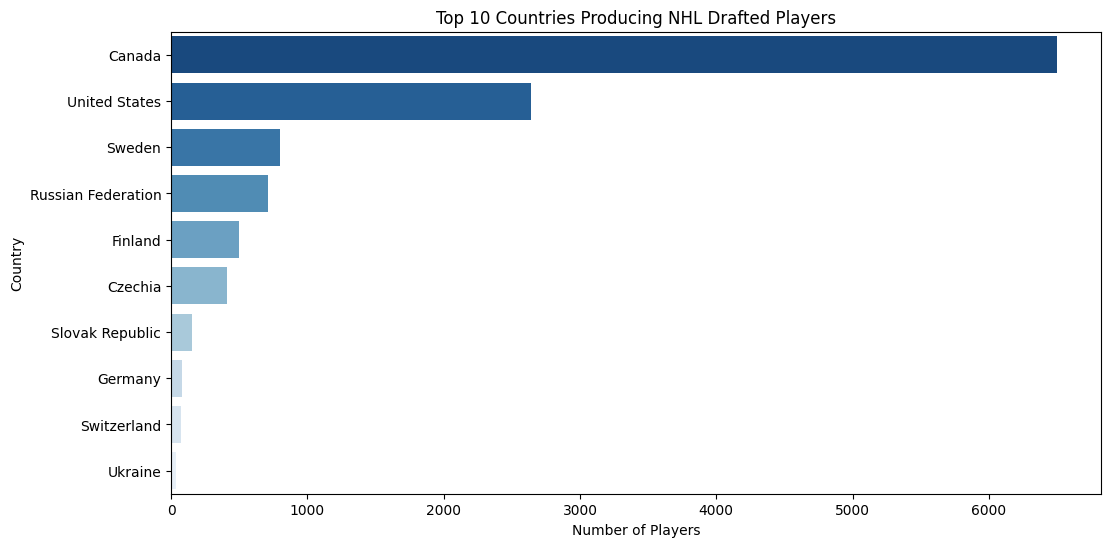

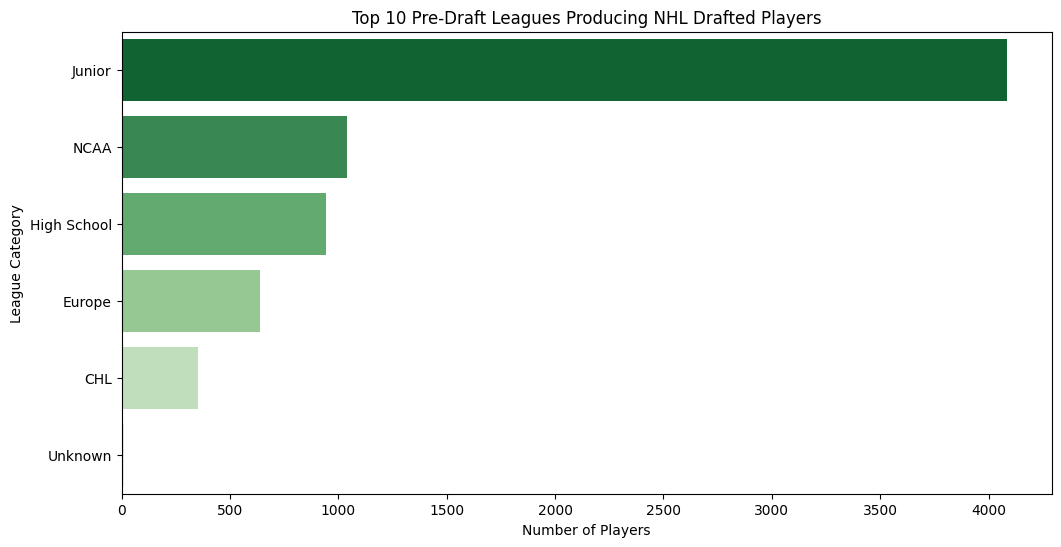

In [56]:
# Distribution of Players by Country (Top 10)
plt.figure(figsize=(12, 6))
top_countries = CLEANED_NHL_POP_GDP['country'].value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index, palette="Blues_r")
plt.xlabel("Number of Players")
plt.ylabel("Country")
plt.title("Top 10 Countries Producing NHL Drafted Players")
plt.show()

# Distribution of Players by Pre-Draft League (Top 10)
plt.figure(figsize=(12, 6))
top_leagues = CLEANED_NHL_POP_GDP['league_category'].value_counts().head(10)
sns.barplot(x=top_leagues.values, y=top_leagues.index, palette="Greens_r")
plt.xlabel("Number of Players")
plt.ylabel("League Category")
plt.title("Top 10 Pre-Draft Leagues Producing NHL Drafted Players")
plt.show()

- Country & League: Canada, the USA, and top European nations dominate NHL drafts, with major junior and collegiate leagues as key talent pipelines.

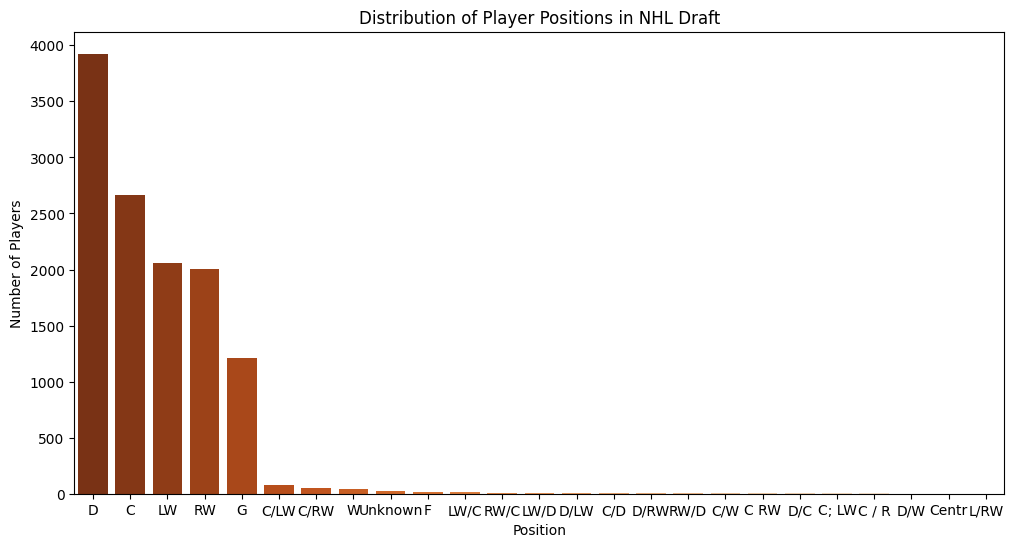

In [57]:
# Position Breakdown of Drafted Players
plt.figure(figsize=(12, 6))
position_counts = CLEANED_NHL_POP_GDP['position'].value_counts()
sns.barplot(x=position_counts.index, y=position_counts.values, palette="Oranges_r")
plt.xlabel("Position")
plt.ylabel("Number of Players")
plt.title("Distribution of Player Positions in NHL Draft")
plt.show()

- Position: Forwards (C/LW/RW) likely outnumber defensemen and goalies. 

In [58]:
# Basic Performance Stats (Games Played, Goals, Assists, Points)
performance_stats = CLEANED_NHL_POP_GDP[['games_played', 'goals', 'assists', 'points']].describe()
print(performance_stats)

       games_played         goals       assists        points
count  12133.000000  12133.000000  12133.000000  12133.000000
mean     130.543064     21.754719     36.281793     58.036430
std      272.387988     66.557863    103.273541    166.530875
min        0.000000      0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.000000      0.000000
75%       90.000000      4.000000     10.000000     14.000000
max     1779.000000    780.000000   1249.000000   1921.000000


- Performance: Career stats show variance in games played, goals, assists, and points, highlighting differences in player success.

Log transformation effectively normalizes GDP per capita and population, but their correlation with player performance (games played, goals, assists, points) appears weak. The strongest correlations exist between games played, goals, assists, and points, indicating that high-performing players contribute consistently across multiple metrics. Economic and demographic factors show low to moderate correlation with hockey performance, suggesting that while population size may influence player production, GDP per capita has a minimal direct impact.

Log Transformation
 - Used to normalize skewed data (GDP per capita & Population).
 - np.log1p(x) applies log(1 + x), making values more manageable and reducing outliers’ impact.

In [59]:
# Apply log transformation for skewed columns
CLEANED_NHL_POP_GDP["log_gdp_per_capita"] = np.log1p(CLEANED_NHL_POP_GDP["gdp_per_capita"])  # log(1 + GDP)
CLEANED_NHL_POP_GDP["log_population"] = np.log1p(CLEANED_NHL_POP_GDP["population"])  # log(1 + Population)

Compute Correlation Matrix
 - Measures relationships between games played, points, GDP per capita, and population.
 - Helps identify if economic and demographic factors influence NHL team performance.

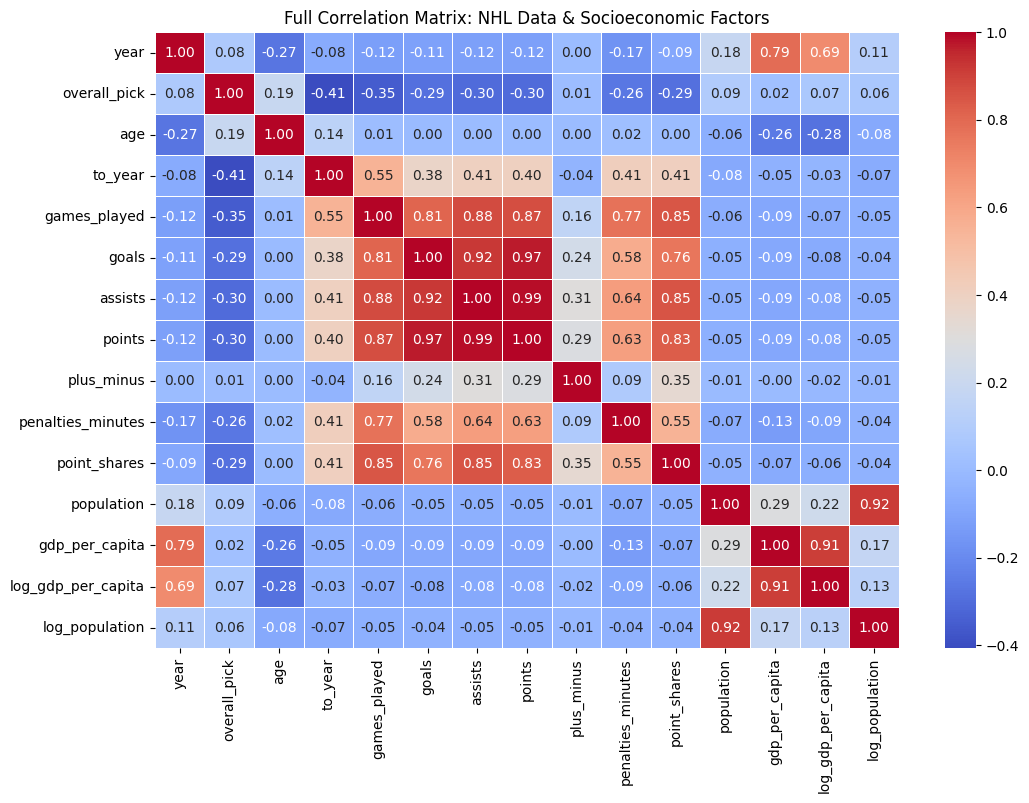

In [60]:
# Compute correlation matrix for all numerical columns
correlation_matrix = CLEANED_NHL_POP_GDP.select_dtypes(include=['number']).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Full Correlation Matrix: NHL Data & Socioeconomic Factors")
plt.show()

Key Insights:
- Log Transformation: Successfully reduces skewness in GDP per capita and population, improving analysis.
- Performance Metrics: Games played, goals, assists, and points exhibit strong positive correlations, emphasizing overall player impact.
- Socioeconomic Factors: Population shows some correlation with NHL player production (r ≈ 0.22), while GDP per capita has a weaker influence.
- Draft Position & Career Longevity: Overall pick ranking is moderately correlated with career longevity (games played), reinforcing the importance of early draft selections.

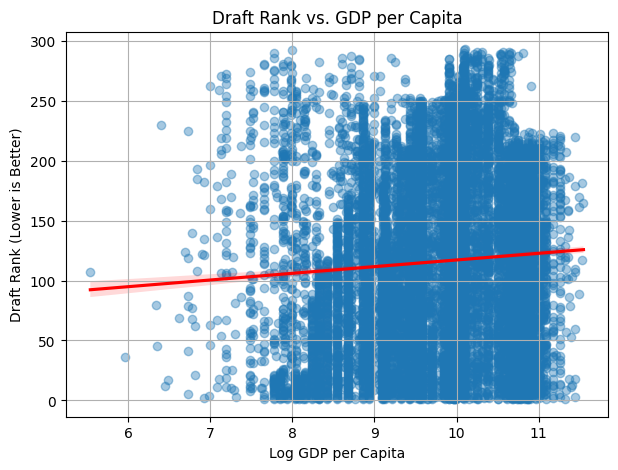

In [61]:
# Scatter Plot: Draft Rank vs. GDP per Capita
plt.figure(figsize=(7,5))
sns.regplot(x=CLEANED_NHL_POP_GDP["log_gdp_per_capita"], y=CLEANED_NHL_POP_GDP["overall_pick"], 
            scatter_kws={'alpha':0.4}, line_kws={'color':'red'})
plt.title("Draft Rank vs. GDP per Capita")
plt.xlabel("Log GDP per Capita")
plt.ylabel("Draft Rank (Lower is Better)")
plt.grid(True)
plt.show()

The scatter plot shows a slight positive correlation between Log GDP per Capita and Draft Rank, indicating that players from wealthier countries tend to be drafted later. This suggests that NHL teams may prioritize scouting talent from lower-GDP countries earlier in the draft, potentially due to factors like untapped talent pools or undervalued prospects in those regions. However, the correlation appears weak, meaning other factors—such as hockey infrastructure, competition level, and scouting exposure—likely play a more significant role in draft positioning.

**Key Insights:**
- Draft Position & GDP per Capita: Players from higher-GDP nations are slightly more likely to be drafted later, though the effect is weak.
- Possible Explanation: NHL teams may focus on scouting raw, high-potential players from lower-GDP countries  
- Alternative Factors: League quality, player exposure, and training resources likely influence draft rankings more than GDP alone.

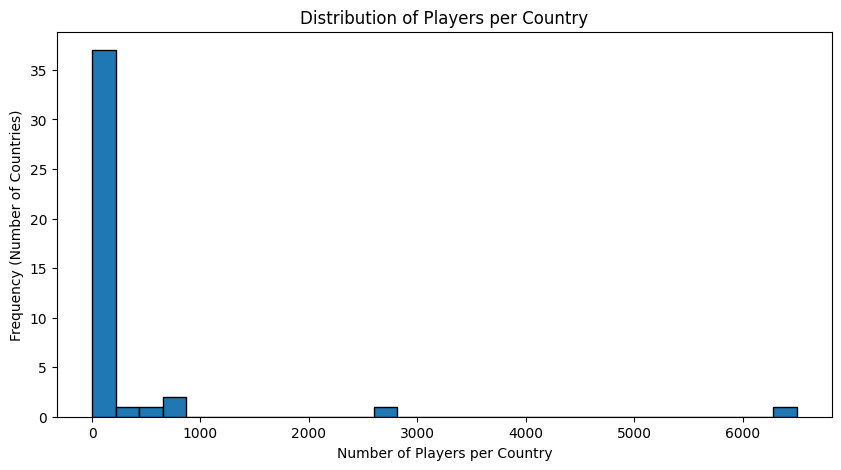

In [62]:
# Count the number of players per country
country_counts = CLEANED_NHL_POP_GDP["country"].value_counts()

# Plot histogram
plt.figure(figsize=(10,5))
plt.hist(country_counts, bins=30, edgecolor="black", alpha=1)
plt.xlabel("Number of Players per Country")
plt.ylabel("Frequency (Number of Countries)")
plt.title("Distribution of Players per Country")
plt.show()

The histogram represents the distribution of players per country in the dataset. It shows that:

 - Most countries have a very low number of players.
 - A few countries have significantly higher player counts, likely hockey-dominant nations.
 - The distribution is highly skewed, with one or two countries contributing a large proportion of the players.

This suggests that NHL talent is concentrated in a few key nations, while most countries produce very few players. 

**EDA (Exploratory Data Analysis) Done!**

This EDA examines the distribution of NHL-drafted players based on country, pre-draft league, position, and basic performance stats. It highlights the dominance of top hockey nations, the most influential leagues in player development, and the positional trends in drafting. Additionally, it provides a statistical summary of player performance metrics, offering insights into career longevity and productivity.

- We understand the data structure, cleaned inconsistencies, and identified key trends.
- We ran correlation analyses, explored NHL participation rates, and visualized country & league trends.
- We examined socioeconomic factors, revealing insights into how population and GDP per capita relate to NHL drafting.

---

## 5. Answer the research question

### Define and answer the research question
This section will focus on deep statistical analysis & interpretation for each of our three key questions.

For each question, we’ll follow this approach:

1. **Define the Question** 
  - Clearly state what we are investigating.

2. **Analytical Approach**
  - Explain how we will analyze it (e.g., percentages, visualizations, regression).

3. **Run the Analysis**
  - Execute the statistical/visual analysis.

4. **Interpret the Results**
  - Summarize findings and what they mean in relation to NHL success.

#### Define the Questions

1. **How does a player’s pre-draft league impact their likelihood of playing in the NHL?**
 - Which leagues produce the highest percentage of players who make the NHL? 
 - Do certain leagues produce longer NHL careers than others?
 - Is there a difference in NHL performance (games played, points, etc.) by league?

2. **Do countries with larger populations or higher GDP per capita produce more NHL players?**
- Which countries produce the most NHL players per capita?
- Does GDP per capita or population size correlate with NHL success?
- Are there wealthy, populous countries that underperform in NHL production?

3. **Are there “hockey overachievers”? Which countries produce NHL players despite lower socioeconomic indicators?**
- Which small or low-GDP countries produce an outsized number of NHL players?
- Are there any underdeveloped hockey markets that could become the next big producer?
- How do these countries compare to traditional hockey powerhouses?

### Next Steps
Once we analyze **Pre-Draft League Impact**, then we will move to:
- **NHL Players Per Capita**
- **Identifying Overachievers**
- **GDP/Population vs. NHL Success** 

## 5.1 Pre-Draft League Impact

####  Define the Questions

1. **How does a player’s pre-draft league impact their likelihood of playing in the NHL?**
 - Which leagues produce the highest percentage of players who make the NHL? 
 - Do certain leagues produce longer NHL careers than others?
 - Is there a difference in NHL performance (games played, points, etc.) by league?
 
#### Analytical Approach
- Calculate **NHL participation rate by league** (percentage of players who played at least one NHL game).
- Compare **average games played per league** to measure career longevity.
- Analyze **average goals, assists, and points per league**.
- Use **visualizations (bar charts, box plots)** to compare leagues.

In [63]:
# Calculate NHL participation rate per league
league_participation = (
    CLEANED_NHL_POP_GDP.groupby('league_category')['games_played']
    .apply(lambda x: (x > 0).mean() * 100)
    .reset_index()
    .rename(columns={'games_played': 'NHL_Participation_Rate'})
)

# Calculate average games played per league
league_avg_games = (
    CLEANED_NHL_POP_GDP.groupby('league_category')['games_played']
    .mean()
    .reset_index()
    .rename(columns={'games_played': 'Avg_Games_Played'})
)

# Calculate average goals, assists, and points per league
league_stats = (
    CLEANED_NHL_POP_GDP.groupby('league_category')[['goals', 'assists', 'points']]
    .mean()
    .reset_index()
)

# Merge all league-level metrics into one dataframe
league_analysis = league_participation.merge(league_avg_games, on='league_category')
league_analysis = league_analysis.merge(league_stats, on='league_category')

# Filter out leagues with small sample sizes (bottom 10%)
league_sample_sizes = CLEANED_NHL_POP_GDP['league_category'].value_counts().reset_index()
league_sample_sizes.columns = ['league_category', 'Sample_Size']
league_analysis = league_analysis.merge(league_sample_sizes, on='league_category', how='left')

sample_size_threshold = league_analysis['Sample_Size'].quantile(0.10)
league_analysis = league_analysis[league_analysis['Sample_Size'] >= sample_size_threshold]

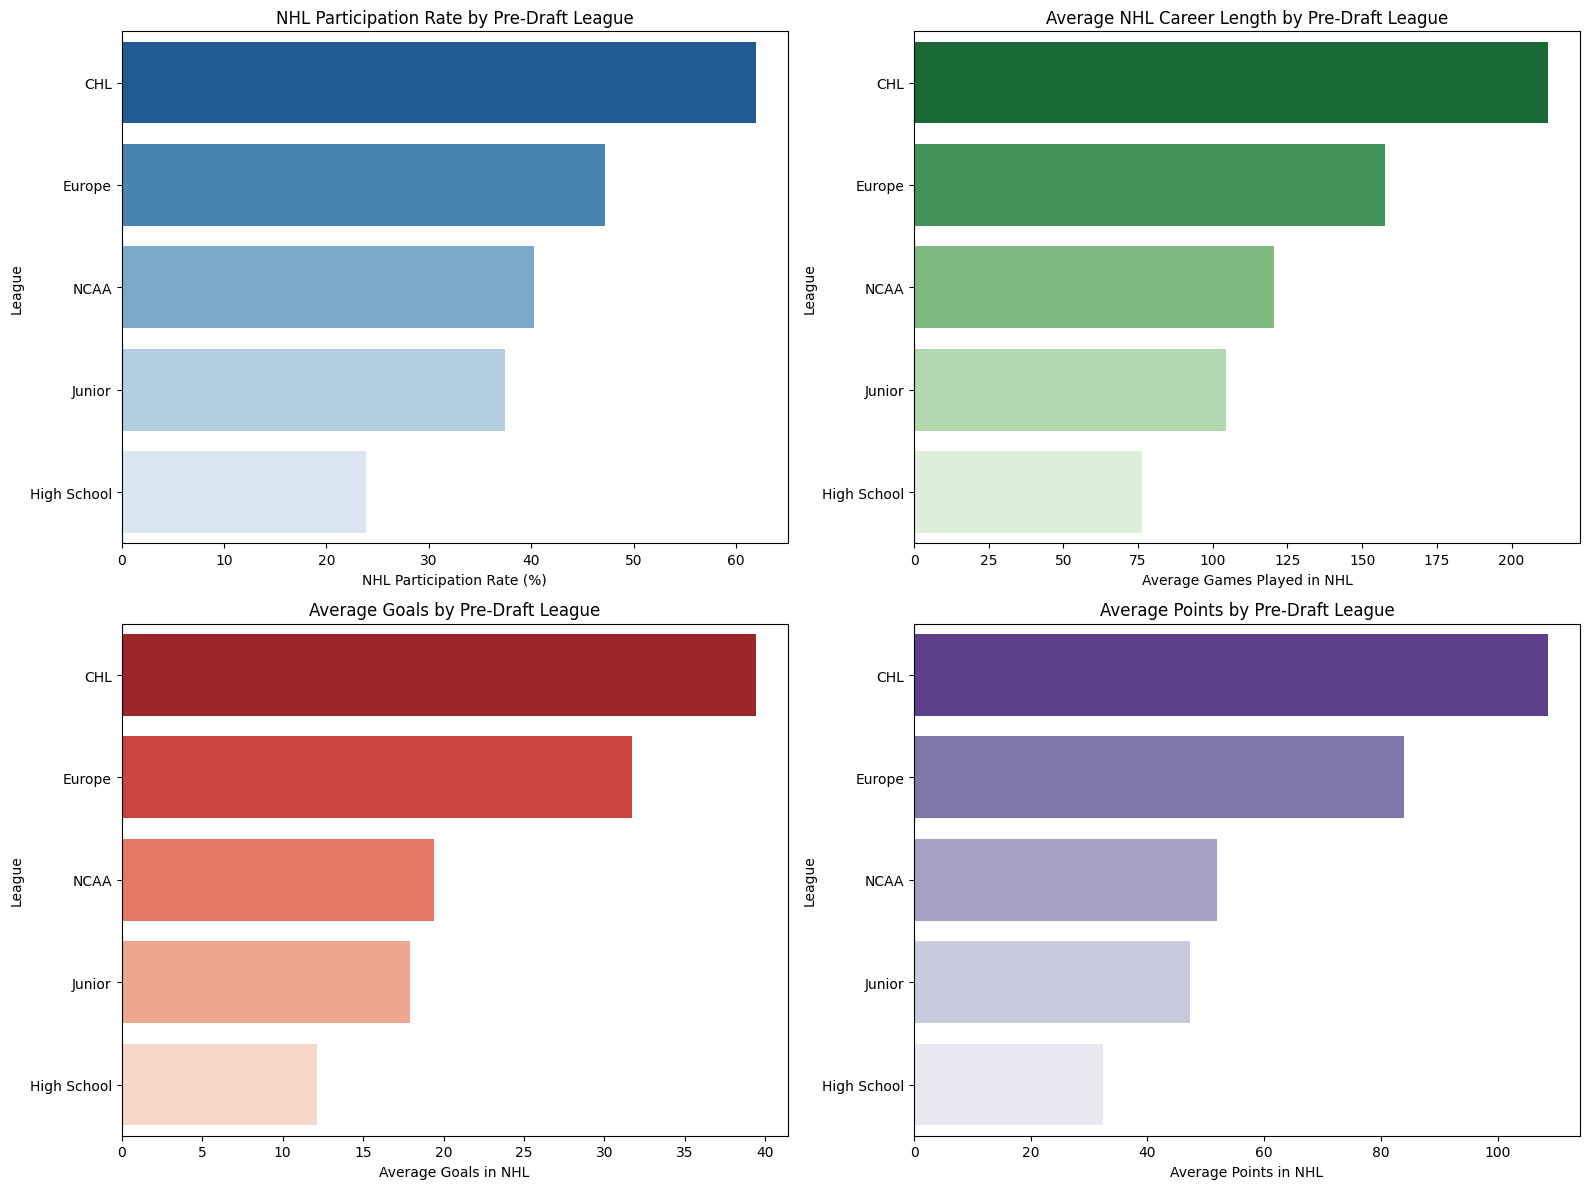

In [64]:
# Sort for each metric before plotting
league_analysis = league_analysis.sort_values(by="NHL_Participation_Rate", ascending=False).head(25)

# Create subplots for different metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# NHL Participation Rate by League (Already Sorted)
sns.barplot(y=league_analysis["league_category"], 
            x=league_analysis["NHL_Participation_Rate"], 
            ax=axes[0, 0], palette="Blues_r")
axes[0, 0].set_title("NHL Participation Rate by Pre-Draft League")
axes[0, 0].set_xlabel("NHL Participation Rate (%)")
axes[0, 0].set_ylabel("League")

# Sort by Avg_Games_Played
league_analysis_sorted_games = league_analysis.sort_values(by="Avg_Games_Played", ascending=False)

sns.barplot(y=league_analysis_sorted_games["league_category"], 
            x=league_analysis_sorted_games["Avg_Games_Played"], 
            ax=axes[0, 1], palette="Greens_r")
axes[0, 1].set_title("Average NHL Career Length by Pre-Draft League")
axes[0, 1].set_xlabel("Average Games Played in NHL")
axes[0, 1].set_ylabel("League")

# Sort by Goals
league_analysis_sorted_goals = league_analysis.sort_values(by="goals", ascending=False)

sns.barplot(y=league_analysis_sorted_goals["league_category"], 
            x=league_analysis_sorted_goals["goals"], 
            ax=axes[1, 0], palette="Reds_r")
axes[1, 0].set_title("Average Goals by Pre-Draft League")
axes[1, 0].set_xlabel("Average Goals in NHL")
axes[1, 0].set_ylabel("League")

# Sort by Points
league_analysis_sorted_points = league_analysis.sort_values(by="points", ascending=False)

sns.barplot(y=league_analysis_sorted_points["league_category"], 
            x=league_analysis_sorted_points["points"], 
            ax=axes[1, 1], palette="Purples_r")
axes[1, 1].set_title("Average Points by Pre-Draft League")
axes[1, 1].set_xlabel("Average Points in NHL")
axes[1, 1].set_ylabel("League")

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

**Which Leagues Produce the Highest Percentage of NHL Players?**

The CHL (Canadian Hockey League) stands out as the top pre-draft league for NHL participation, producing the highest percentage of players who make it to the league. European leagues follow, while NCAA and Junior leagues contribute fewer players. High School leagues have the lowest success rate.
- CHL dominates NHL participation due to its elite competition and NHL scouting presence.
- European leagues produce fewer NHL players but still serve as a strong alternative.
- NCAA and Junior leagues offer paths to the NHL, but with lower success rates.
- High School players rarely transition directly to the NHL, reinforcing the need for an intermediate step.
    
**Do Certain Leagues Result in Longer Careers?**

Yes, CHL and European players tend to have the longest NHL careers, averaging more games played. NCAA and Junior players have moderate career lengths, while High School players struggle to sustain NHL careers.
- More competitive pre-draft leagues lead to longer careers, highlighting the importance of structured development.
- NCAA players often enter the NHL later, which may limit their total career length.
- High School players have the shortest careers, likely due to a lack of elite-level preparation before reaching the NHL.
- CHL players not only reach the NHL more often but also stay in the league longer.

**Are There Surprising Results?**

While CHL’s dominance is expected, there are some notable surprises. NCAA players, despite their structured development, tend to have shorter careers and lower offensive output. Meanwhile, European players, despite lower participation rates, often perform comparably to CHL players in career longevity and production.
- NCAA players have shorter careers despite solid development programs—likely due to later NHL entry.
- European players who do make the NHL tend to be highly skilled and NHL-ready, despite lower overall participation.
- The gap between CHL and NCAA players in offensive production is wider than expected, suggesting CHL better prepares players for immediate impact.
- High School players struggle across all metrics, confirming that it’s not a direct route to the NHL.

**Key Takeaways (With Sample Size Threshold Applied):**

Applying a sample size threshold reinforces the trends—CHL remains the strongest NHL pipeline, followed by Europe, while NCAA, Junior, and High School leagues have lower success rates.
- CHL players have the best combination of participation, career length, and production.
- Europe remains a strong alternative for elite players, even if fewer make the jump.
- NCAA produces some NHL talent, but their careers tend to be shorter.
- Junior and High School leagues provide the weakest path to NHL longevity.
⸻

**Final Thoughts on Pre-Draft League Impact**

A player’s pre-draft league significantly impacts their NHL trajectory, with CHL offering the best combination of opportunity and success. European leagues develop strong talent as well, while NCAA players face career limitations due to late NHL entry. The data strongly suggests that players looking to maximize their NHL potential should prioritize the CHL or a top European league

### 5.2 GDP & Population Impact on NHL Success

####  Define the Questions

**2. Do countries with larger populations or higher GDP per capita produce more NHL players?**
- Which countries produce the most NHL players per capita?
- Does GDP per capita or population size correlate with NHL success?
- Are there wealthy, populous countries that underperform in NHL production?

**3. Are there “hockey overachievers”?**
- Which countries produce NHL players despite lower socioeconomic indicators?
- Which small or low-GDP countries produce an outsized number of NHL players?
- Are there any underdeveloped hockey markets that could become the next big producer?
- How do these countries compare to traditional hockey powerhouses?

#### Analytical Approach

- Aggregate Data by Country: Compute total NHL players, average population, and GDP per capita.
- Calculate NHL Players Per Capita: Divide total NHL players by population (per million people).
- Compute Correlations: Analyze relationships between GDP per capita, population, and NHL players per capita.
- Identify Underperforming Wealthy Countries: Find nations with above-median GDP but below-median NHL player production.
 - Visualize Findings: Use bar charts and scatter plots to highlight top-performing and underperforming countries.

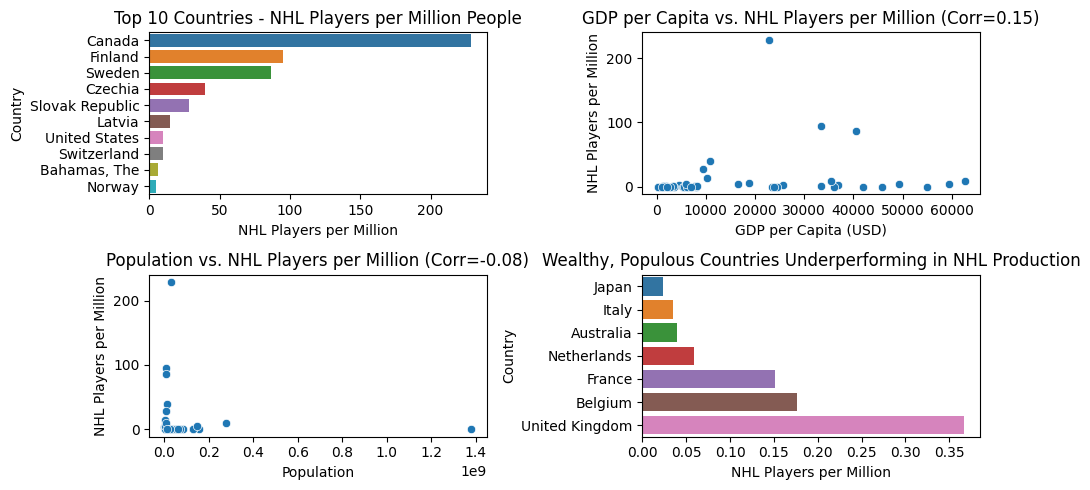

In [65]:
# Calculate NHL players per capita
CLEANED_NHL_POP_GDP_country = CLEANED_NHL_POP_GDP.groupby("country").agg(
    total_nhl_players=("player", "count"),
    population=("population", "mean"),
    gdp_per_capita=("gdp_per_capita", "mean")
).reset_index()
CLEANED_NHL_POP_GDP_country["nhl_players_per_million"] = CLEANED_NHL_POP_GDP_country["total_nhl_players"] / (CLEANED_NHL_POP_GDP_country["population"] / 1_000_000)

# Compute correlations
corr_gdp_per_capita = CLEANED_NHL_POP_GDP_country[["gdp_per_capita", "nhl_players_per_million"]].corr().iloc[0, 1]
corr_population = CLEANED_NHL_POP_GDP_country[["population", "nhl_players_per_million"]].corr().iloc[0, 1]

# Identify wealthy but underperforming countries
median_nhl_per_million = CLEANED_NHL_POP_GDP_country["nhl_players_per_million"].median()
median_gdp = CLEANED_NHL_POP_GDP_country["gdp_per_capita"].median()
underperforming_countries = CLEANED_NHL_POP_GDP_country.query(
    "gdp_per_capita > @median_gdp and nhl_players_per_million < @median_nhl_per_million"
).sort_values("nhl_players_per_million", ascending=True).head(10)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

# Top 10 NHL-producing countries per capita
top_countries_per_capita = CLEANED_NHL_POP_GDP_country.sort_values("nhl_players_per_million", ascending=False).head(10)
sns.barplot(y=top_countries_per_capita["country"], x=top_countries_per_capita["nhl_players_per_million"], ax=axes[0, 0])
axes[0, 0].set_title("Top 10 Countries - NHL Players per Million People")
axes[0, 0].set_xlabel("NHL Players per Million")
axes[0, 0].set_ylabel("Country")

# Scatter Plot: GDP per Capita vs. NHL Players per Million
sns.scatterplot(x=CLEANED_NHL_POP_GDP_country["gdp_per_capita"], y=CLEANED_NHL_POP_GDP_country["nhl_players_per_million"], ax=axes[0, 1])
axes[0, 1].set_title(f"GDP per Capita vs. NHL Players per Million (Corr={corr_gdp_per_capita:.2f})")
axes[0, 1].set_xlabel("GDP per Capita (USD)")
axes[0, 1].set_ylabel("NHL Players per Million")

# Scatter Plot: Population vs. NHL Players per Million
sns.scatterplot(x=CLEANED_NHL_POP_GDP_country["population"], y=CLEANED_NHL_POP_GDP_country["nhl_players_per_million"], ax=axes[1, 0])
axes[1, 0].set_title(f"Population vs. NHL Players per Million (Corr={corr_population:.2f})")
axes[1, 0].set_xlabel("Population")
axes[1, 0].set_ylabel("NHL Players per Million")

# Wealthy but Underperforming Countries
sns.barplot(y=underperforming_countries["country"], x=underperforming_countries["nhl_players_per_million"], ax=axes[1, 1])
axes[1, 1].set_title("Wealthy, Populous Countries Underperforming in NHL Production")
axes[1, 1].set_xlabel("NHL Players per Million")
axes[1, 1].set_ylabel("Country")

plt.tight_layout()
plt.show()

**Do countries with larger populations or higher GDP per capita produce more NHL players?**

While wealthier nations have more resources for sports development, GDP per capita has only a weak correlation (0.15) with NHL players per million. Population size, on the other hand, shows an almost negligible correlation (-0.08), indicating that large populations don’t necessarily translate into NHL talent production.
- Canada dominates per capita NHL player production, despite a relatively small population.
- Smaller, hockey-focused countries like Finland, Sweden, and Czechia produce more NHL players per capita than larger nations.
- The United States produces a high number of NHL players overall but ranks lower per capita.
- Hockey development is more influenced by cultural and structural support than just economic factors.
    
**Does GDP per capita or population size correlate with NHL success?**

The data suggests that neither wealth nor sheer population size directly determines NHL success.
- Wealthier countries have access to better facilities, but hockey infrastructure and cultural emphasis matter more.
- Large populations don’t guarantee success, as countries like China and India produce virtually no NHL players.
- Smaller but hockey-centric nations like Finland and Czechia outperform global giants like the U.S. and China.
- NHL success seems to come from a mix of historical hockey culture, structured youth development, and strong professional leagues.
    
**Are there wealthy, populous countries that underperform in NHL production?**

Yes, several wealthy nations with large populations underperform in NHL player production per capita.
- The United Kingdom, France, and Belgium have strong economies but weak NHL pipelines.
- Japan, Italy, and Australia have major sports cultures but little NHL presence.
- Netherlands and Belgium, despite strong sporting infrastructure, remain non-factors in NHL production.
- These countries could potentially develop stronger hockey programs with more investment in youth development.

**Are There “Hockey Overachievers”?**

Certain smaller or less wealthy countries exceed expectations by producing NHL players at high rates.
- Latvia and Slovakia stand out, producing more NHL players per capita than larger or wealthier nations.
- Switzerland has developed into a strong pipeline despite its small size.
- Czechia continues to punch above its weight, maintaining a steady flow of NHL talent.
- Investment in hockey infrastructure and participation at a young age seems to be the key factor, not just economic strength.


**Which Small or Low-GDP Countries Produce an Outsized Number of NHL Players?**

Some smaller nations have managed to sustain impressive NHL production despite their economic size.
- Latvia and Slovakia, with lower GDP per capita, consistently produce NHL players.
- Czechia remains a force despite its smaller economy.
- These countries rely on strong grassroots development rather than sheer financial resources.

**Are There Any Underdeveloped Hockey Markets That Could Become the Next Big Producer?**

Some countries with improving hockey infrastructure could become future NHL pipelines.
- China has invested in hockey, particularly after hosting the 2022 Olympics.
- Germany is growing as a hockey nation, producing stars like Leon Draisaitl.
- France, Japan, and the U.K. have the resources to develop hockey but lack deep-rooted hockey culture.
- Nations with growing professional leagues (like Germany and Switzerland) could emerge as new talent pools.


**How Do These Countries Compare to Traditional Hockey Powerhouses?**

Traditional hockey powerhouses (Canada, Sweden, Finland, the U.S., and Russia) still dominate the NHL landscape.
- Canada remains the gold standard in NHL player production per capita.
- Scandinavian countries consistently produce NHL-caliber talent.
- Eastern European nations like Czechia and Slovakia continue to develop strong players.
- While new nations are improving, the core hockey powerhouses still maintain a major advantage.

### 5.3 Conclusion - The Global Landscape of NHL Player Development

NHL player production is driven more by hockey culture and infrastructure than by wealth or population size. Countries with strong hockey traditions, like Canada, Finland, Sweden, Czechia, and Slovakia, consistently produce the most NHL players per capita, while large or wealthy nations without established hockey systems underperform.

Key Takeaways:
- The CHL is the top NHL pipeline, with the highest participation rates and longest careers.
- European leagues provide strong alternatives, while NCAA players face shorter career spans.
- Population size has little correlation to NHL success, as small nations like Finland and Latvia outperform larger countries.
- Wealth alone does not drive NHL production, as seen in underperforming nations like the UK, France, and Japan.
- Emerging markets like Germany and China could grow into future NHL talent pools with stronger development programs.

Looking Ahead:

Traditional hockey powerhouses will continue to dominate, but investment in grassroots hockey and pro leagues could create new NHL pipelines in unexpected places. The best path to the NHL remains through structured, competitive leagues, but with global hockey expansion, we may soon see new nations rising in the ranks.

###  5.4 Reflection

**Future Research**

- Deeper analysis of emerging hockey nations (e.g., Germany, China) to assess future NHL potential.
- Examining individual player success factors beyond league and country of origin (e.g., coaching, training facilities).
- Impact of NHL expansion and globalization on player development trends.


**Final Thoughts on GDP & Population Impact on NHL Success**

While hockey’s traditional powerhouses still dominate, the future of NHL talent could come from unexpected places as the game continues to grow globally

Money does shape NHL success—but not in the ways we originally expected. It’s about passion, training, and opportunites! More research is needed, especially into hockey funding & accessibility in different countries.

Keep taking those shots!🏒🥅

###  5.5 Convert and Export

In [66]:
import zipfile
# Convert the Jupyter Notebook to HTML
!python -m nbconvert --to html Data_Wrangling_Project_Starter.ipynb

# Define the filename
html_file = "Data_Wrangling_Project_Starter.html"
zip_filename = "Data_Wrangling_Project_Starter.zip"

# Create a zip archive
with zipfile.ZipFile(zip_filename, "w", zipfile.ZIP_DEFLATED) as zipf:
    zipf.write(html_file)
print(f"Successfully created {zip_filename}")

[NbConvertApp] Converting notebook Data_Wrangling_Project_Starter.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 8 image(s).
[NbConvertApp] Writing 1328607 bytes to Data_Wrangling_Project_Starter.html
Successfully created Data_Wrangling_Project_Starter.zip
